In [1]:
!pip install --quiet torch torchvision tqdm pillow

In [2]:
# ==================================================
# 1. 기본 설치 & 임포트
# ==================================================
import os, random, itertools, math, time, json
from pathlib import Path
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("✅ device:", DEVICE)


✅ device: cuda


In [3]:
# ==================================================
# 2. 하이퍼파라미터
# ==================================================
BATCH_SIZE   = 64
LATENT_DIM   = 100        # z 벡터 차원
LR           = 2e-4
EPOCHS       = 20
IMG_SIZE     = 28

SAVE_DIR     = Path("dcgan_mnist")
SAVE_DIR.mkdir(exist_ok=True)


In [4]:
# ==================================================
# 3. 데이터셋 (MNIST)
# ==================================================
transform = transforms.Compose([
    transforms.ToTensor(),                # [0,1]
    transforms.Normalize((0.5,), (0.5,))  # [-1,1]  (tanh 활성화를 위해)
])

train_ds = datasets.MNIST(root="~/data", train=True, download=True,
                          transform=transform)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE,
                          shuffle=True)


In [5]:
# ==================================================
# 4. DCGAN Generator & Discriminator
# ==================================================
class Generator(nn.Module):
    def __init__(self, z_dim=LATENT_DIM, img_chan=1, feat_g=64):
        super().__init__()
        self.net = nn.Sequential(
            # (N, z_dim, 1, 1) → (N, feat_g*4, 4, 4)
            nn.ConvTranspose2d(z_dim, feat_g*4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(feat_g*4),
            nn.ReLU(),

            # 4×4 → 7×7
            nn.ConvTranspose2d(feat_g*4, feat_g*2, 3, 2, 1, bias=False),
            nn.BatchNorm2d(feat_g*2),
            nn.ReLU(),

            # 7×7 → 14×14
            nn.ConvTranspose2d(feat_g*2, feat_g, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feat_g),
            nn.ReLU(),

            # 14×14 → 28×28
            nn.ConvTranspose2d(feat_g, img_chan, 4, 2, 1, bias=False),
            nn.Tanh()    # [-1,1]
        )

    def forward(self, z):
        return self.net(z)

class Discriminator(nn.Module):
    def __init__(self, img_chan=1, feat_d=64):
        super().__init__()
        self.net = nn.Sequential(
            # 28×28 → 14×14
            nn.Conv2d(img_chan, feat_d, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),

            # 14×14 → 7×7
            nn.Conv2d(feat_d, feat_d*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feat_d*2),
            nn.LeakyReLU(0.2),

            # 7×7 → 4×4
            nn.Conv2d(feat_d*2, feat_d*4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(feat_d*4),
            nn.LeakyReLU(0.2),

            # 4×4 → 1×1
            nn.Conv2d(feat_d*4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x).view(-1, 1)


In [6]:
# 모델 초기화
G = Generator().to(DEVICE)
D = Discriminator().to(DEVICE)
print(f"Generator 파라미터: {sum(p.numel() for p in G.parameters()):,}")
print(f"Discriminator 파라미터: {sum(p.numel() for p in D.parameters()):,}")


Generator 파라미터: 837,504
Discriminator 파라미터: 431,872


In [7]:
# ==================================================
# 5. 손실 & 옵티마이저
# ==================================================
criterion = nn.BCELoss()
opt_G = torch.optim.Adam(G.parameters(), lr=LR, betas=(0.5, 0.999))
opt_D = torch.optim.Adam(D.parameters(), lr=LR, betas=(0.5, 0.999))

fixed_noise = torch.randn(BATCH_SIZE, LATENT_DIM, 1, 1, device=DEVICE)


In [8]:
fixed_noise.shape

torch.Size([64, 100, 1, 1])

In [9]:
# ==================================================
# 6. 학습
# ==================================================
def save_samples(step):
    with torch.no_grad():
        fake = G(fixed_noise).detach().cpu()
    utils.save_image(fake, SAVE_DIR / f"sample_{step:04d}.png",
                     nrow=8, normalize=True, value_range=(-1,1))

step = 0
G.train(); D.train()
for epoch in range(1, EPOCHS+1):
    pbar = tqdm(train_loader, desc=f"[Epoch {epoch}/{EPOCHS}]")
    for real, _ in pbar:
        B = real.size(0)
        real = real.to(DEVICE)

        # ── 1. Discriminator ─────────────────────────
        noise = torch.randn(B, LATENT_DIM, 1, 1, device=DEVICE)
        fake  = G(noise)

        D_real = D(real).view(-1)
        D_fake = D(fake.detach()).view(-1)

        loss_D = criterion(D_real, torch.ones_like(D_real)) + \
                 criterion(D_fake, torch.zeros_like(D_fake))

        opt_D.zero_grad(); loss_D.backward(); opt_D.step()

        # ── 2. Generator ─────────────────────────────
        D_fake = D(fake).view(-1)
        loss_G = criterion(D_fake, torch.ones_like(D_fake))

        opt_G.zero_grad(); loss_G.backward(); opt_G.step()

        pbar.set_postfix({
            "loss_D": f"{loss_D.item():.3f}",
            "loss_G": f"{loss_G.item():.3f}"
        })
        step += 1

    save_samples(epoch)
    torch.save(G.state_dict(), SAVE_DIR / "G_last.pth")
    torch.save(D.state_dict(), SAVE_DIR / "D_last.pth")

print("학습 완료!")


[Epoch 1/20]:   0%|          | 0/938 [00:00<?, ?it/s]

[Epoch 2/20]:   0%|          | 0/938 [00:00<?, ?it/s]

[Epoch 3/20]:   0%|          | 0/938 [00:00<?, ?it/s]

[Epoch 4/20]:   0%|          | 0/938 [00:00<?, ?it/s]

[Epoch 5/20]:   0%|          | 0/938 [00:00<?, ?it/s]

[Epoch 6/20]:   0%|          | 0/938 [00:00<?, ?it/s]

[Epoch 7/20]:   0%|          | 0/938 [00:00<?, ?it/s]

[Epoch 8/20]:   0%|          | 0/938 [00:00<?, ?it/s]

[Epoch 9/20]:   0%|          | 0/938 [00:00<?, ?it/s]

[Epoch 10/20]:   0%|          | 0/938 [00:00<?, ?it/s]

[Epoch 11/20]:   0%|          | 0/938 [00:00<?, ?it/s]

[Epoch 12/20]:   0%|          | 0/938 [00:00<?, ?it/s]

[Epoch 13/20]:   0%|          | 0/938 [00:00<?, ?it/s]

[Epoch 14/20]:   0%|          | 0/938 [00:00<?, ?it/s]

[Epoch 15/20]:   0%|          | 0/938 [00:00<?, ?it/s]

[Epoch 16/20]:   0%|          | 0/938 [00:00<?, ?it/s]

[Epoch 17/20]:   0%|          | 0/938 [00:00<?, ?it/s]

[Epoch 18/20]:   0%|          | 0/938 [00:00<?, ?it/s]

[Epoch 19/20]:   0%|          | 0/938 [00:00<?, ?it/s]

[Epoch 20/20]:   0%|          | 0/938 [00:00<?, ?it/s]

학습 완료!


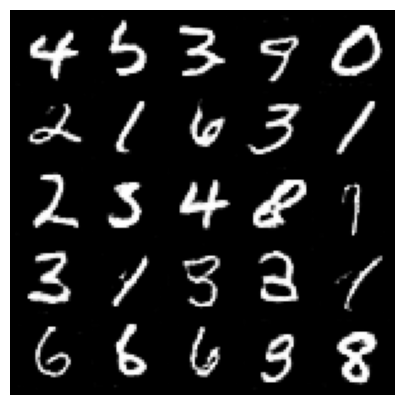

In [10]:
# ==================================================
# 7. 학습된 모델로 샘플 생성
# ==================================================
G.load_state_dict(torch.load(SAVE_DIR / "G_last.pth", map_location=DEVICE))
G.eval()

with torch.no_grad():
    z = torch.randn(25, LATENT_DIM, 1, 1, device=DEVICE)
    fake_imgs = G(z).cpu()

# ── 그리드 만들기 ────────────────────────────────────
grid = utils.make_grid(fake_imgs, nrow=5,
                       normalize=True, value_range=(-1, 1))

import matplotlib.pyplot as plt
plt.figure(figsize=(5, 5))
plt.imshow(grid.permute(1, 2, 0))   # (C,H,W) → (H,W,C)
plt.axis("off")
plt.show()
